In [1]:
# Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import geopandas as gpd

# Center For Community Service
#### Project: Data Analysis on E-bike Survey Collected on 04/29/2023

## Part I: Data Cleaning

##### CSV File 1: 4.29.2023_Survey_Results.csv

In [2]:
# Read survey data from the csv file
df = pd.read_csv("4.29.2023_Survey_Results.csv")
df.head()

,Timestamp,Who took this survey (initials),Are you a bike rider?,What is your zip code?,Do you or anyone in your family ride an e-bike?,"How do you commute - to work, school, or for other purposes?",How far (ROUND TRIP) do you commute for any purpose each day?,Would you commute by e-bike if given the opportunity?,"Do you know the differences between Class 1, Class 1, and Class 3 e-bikes?",How comfortable would you be storing your bike in a bike locker while you are commuting? -- secure private locker like this:,How comfortable would you be storing your bike in a bike locker while you are commuting? -- group locker like this:,How familiar are you and those in your family with the rules of the road for e-bikes?,How concerned are you about e-bikes and e-bike safety in San Diego County?,Are you interested in learning more about e-bikes?,Any additional comments?,Who's survey is this?,Unnamed: 16
0,"April 29, 2023",JTB,No,92115.0,No,I do not commute,NaN,Maybe,No,Very,Very,Don't know,Not very,No,NaN,carsonator0898@gmail.com,NaN
1,"April 29, 2023",JTB,No,92129.0,No,Car,No,No,A bit,NaN,NaN,Not very,somewhat,No,NaN,NaN,NaN
2,"April 29, 2023",JTB,No,92115.0,Dad,Public transportation,1 mile,Maybe,A bit,Very,somewhat,Don't know,Very,Yes,NaN,risela.delosangles@gmail.com,NaN
3,"April 29, 2023",JTB,No,92562.0,No,I do not commute,NaN,NaN,No,NaN,NaN,Don't know,Not concerned,May be,NaN,NaN,NaN
4,"April 29, 2023",JTB,Yes,92109.0,No,I do not commute,NaN,NaN,No,NaN,NaN,Don't know,Not concerned,No,NaN,NaN,NaN


In [3]:
df.shape

(65, 17)

In [4]:
# Keep numerical and binary columns
quant_df = df.drop("Who took this survey (initials)", axis=1)
quant_df.drop("Any additional comments?", axis=1, inplace=True)
quant_df.drop("Who's survey is this?", axis=1, inplace=True)
quant_df.drop("Timestamp", axis=1, inplace=True)
quant_df.drop("Unnamed: 16", axis=1, inplace=True)

# Change headers
quant_df.columns = ['bike_rider', 'zipcode', 'ebike_rider', 'commute_purpose',
                   'miles', 'try_bike', 'ebike_class', 'private_locker', 'group_locker',
                   'ebike_rules', 'safty', 'interested']

quant_df.head()

,bike_rider,zipcode,ebike_rider,commute_purpose,miles,try_bike,ebike_class,private_locker,group_locker,ebike_rules,safty,interested
0,No,92115.0,No,I do not commute,NaN,Maybe,No,Very,Very,Don't know,Not very,No
1,No,92129.0,No,Car,No,No,A bit,NaN,NaN,Not very,somewhat,No
2,No,92115.0,Dad,Public transportation,1 mile,Maybe,A bit,Very,somewhat,Don't know,Very,Yes
3,No,92562.0,No,I do not commute,NaN,NaN,No,NaN,NaN,Don't know,Not concerned,May be
4,Yes,92109.0,No,I do not commute,NaN,NaN,No,NaN,NaN,Don't know,Not concerned,No


In [5]:
quant_df.shape

(65, 12)

Here's a description of each feature (column) in the quant_df DataFrame:

Header | Description
-------|------------
bike_rider | Are you a bike rider?
zipcode | What is your zip code?
ebike_rider | Do you or anyone in your family ride an e-bike?
commute_purpose | How do you commute - to work, school, or for other purposes?
miles | How far (ROUND TRIP) do you commute for any purpose each day?
try_bike | Would you commute by e-bike if given the opportunity?
ebike_class | Do you know the differences between Class 1, Class 1, and Class 3 e-bikes?
private_locker | How comfortable would you be storing your bike in a private bike locker while you are commuting?
group_locker | How comfortable would you be storing your bike in a group bike locker while you are commuting?
ebike_rules | How familiar are you and those in your family with the rules of the road for e-bikes?
safty | How concerned are you about e-bikes and e-bike safety in San Diego County?
interested | Are you interested in learning more about e-bikes?


In [6]:
# convert all letters to lowercase
columns = quant_df.columns
for column in columns:
    if column != 'zipcode':
        quant_df[column] = quant_df[column].str.lower()


# remove unit in miles
quant_df.head()

,bike_rider,zipcode,ebike_rider,commute_purpose,miles,try_bike,ebike_class,private_locker,group_locker,ebike_rules,safty,interested
0,no,92115.0,no,i do not commute,NaN,maybe,no,very,very,don't know,not very,no
1,no,92129.0,no,car,no,no,a bit,NaN,NaN,not very,somewhat,no
2,no,92115.0,dad,public transportation,1 mile,maybe,a bit,very,somewhat,don't know,very,yes
3,no,92562.0,no,i do not commute,NaN,NaN,no,NaN,NaN,don't know,not concerned,may be
4,yes,92109.0,no,i do not commute,NaN,NaN,no,NaN,NaN,don't know,not concerned,no


In [7]:
# Remove cell with a time unit
quant_df['miles'] = quant_df['miles'].astype(str)
quant_df['miles'] = quant_df['miles'].apply(lambda x: np.nan if pd.isnull(x) or 'min' in x else x)

# miles column cleaning - keep numbers only
quant_df['miles'] = quant_df['miles'].str.extract(r'(\d+)', expand=False).astype(float).astype(pd.Int64Dtype())
quant_df.head()

,bike_rider,zipcode,ebike_rider,commute_purpose,miles,try_bike,ebike_class,private_locker,group_locker,ebike_rules,safty,interested
0,no,92115.0,no,i do not commute,<NA>,maybe,no,very,very,don't know,not very,no
1,no,92129.0,no,car,<NA>,no,a bit,NaN,NaN,not very,somewhat,no
2,no,92115.0,dad,public transportation,1,maybe,a bit,very,somewhat,don't know,very,yes
3,no,92562.0,no,i do not commute,<NA>,NaN,no,NaN,NaN,don't know,not concerned,may be
4,yes,92109.0,no,i do not commute,<NA>,NaN,no,NaN,NaN,don't know,not concerned,no


##### CSV File 2: 6.08.2023_Online_Survey_Results.csv

In [8]:
df2= pd.read_csv("6.08.2023_Online_Survey_Results.csv")
df2

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q10,Q11,Q12,Q14,Q12 - Topics,Q12 - Parent Topics,Q14 - Topics,Q14 - Parent Topics,Q12 - Topic Hierarchy Level 1,Q14 - Topic Hierarchy Level 1
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,How concern are you about e-bikes and e-bike s...,Are you interested in learning more about e-bi...,Any additional thoughts or comments?,Will you share your email so we can share addi...,Q12 - Topics,Q12 - Parent Topics,Q14 - Topics,Q14 - Parent Topics,Q12 - Topic Hierarchy Level 1,Q14 - Topic Hierarchy Level 1
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""QID10""}","{""ImportId"":""QID11""}","{""ImportId"":""QID12_TEXT""}","{""ImportId"":""QID14_TEXT""}","{""ImportId"":""QID12_TEXT_b077f173_acwapq7pdun3T...","{""ImportId"":""QID12_TEXT_b077f173_acwapq7pdun3P...","{""ImportId"":""QID14_TEXT_b077f173_4l0j2qic9q6pT...","{""ImportId"":""QID14_TEXT_b077f173_4l0j2qic9q6pP...","{""ImportId"":""QID12_TEXT_b077f173_acwapq7pdun3T...","{""ImportId"":""QID14_TEXT_b077f173_4l0j2qic9q6pT..."
2,2023-05-01 11:37:59,2023-05-01 11:39:22,Survey Preview,NaN,100,82,True,2023-05-01 11:39:23,R_3qe6UiEAvEfILiG,NaN,...,Not very,Yes,NaN,yes,NaN,NaN,Unknown,NaN,NaN,NaN
3,2023-05-01 11:56:26,2023-05-01 11:56:34,IP Address,128.54.0.29,8,8,False,2023-05-08 11:56:35,R_r22TjvRK1FENO6J,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-05-01 11:56:27,2023-05-01 15:41:59,IP Address,174.66.189.65,62,13531,False,2023-05-08 15:42:03,R_1g7oEm3WFlUugjc,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2023-05-25 19:51:07,2023-05-25 19:51:28,IP Address,166.199.151.142,23,20,False,2023-06-01 19:51:34,R_2YhWiUdbqFV6tgr,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,2023-05-25 22:34:28,2023-05-25 22:34:34,IP Address,72.22.164.236,8,6,False,2023-06-01 22:34:38,R_2X0y0cEgvBKvE67,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,2023-05-26 01:26:57,2023-05-26 01:27:26,IP Address,128.54.152.179,31,29,False,2023-06-02 01:27:28,R_Z7XIE13xJPVltEl,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,2023-05-26 08:20:36,2023-05-26 08:22:33,IP Address,172.58.19.160,77,117,False,2023-06-02 08:22:35,R_1k1eTFB14SH5zqQ,NaN,...,Somewhat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Keep question columns only
df2 = df2[['Q1', 'Q2', 'Q3',
           'Q4_1', 'Q4_2', 'Q4_3', 'Q4_4', 
           'Q4_5', 'Q4_6', 'Q4_7', 'Q5', 'Q6',
           'Q7', 'Q8', 'Q9', 'Q10', 'Q11']]

# Drop row 1
df2 = df2.drop(1)

In [10]:
# Change column names
df2.columns = ['bike_rider', 'zipcode', 'ebike_rider', 'commute_purpose_1', 'commute_purpose_2',
               'commute_purpose_3', 'commute_purpose_4', 'commute_purpose_5', 'commute_purpose_6',
               'commute_purpose_7', 'miles', 'try_bike', 'ebike_class', 'locker',
               'ebike_rules', 'safty', 'interested']
df2 = df2.drop(0)

In [11]:
# Set cells to null if its unit is time
df2['miles'] = df2['miles'].apply(lambda x: np.nan if pd.isnull(x) or 'min' in x else x)
df2['miles'] = df2['miles'].str.extract(r'(\d+)', expand=False).astype(float).astype(pd.Int64Dtype())

In [12]:
# Keep U.S. zipcodes only
df2['zipcode'] = df2['zipcode'].apply(lambda x: np.nan if pd.isnull(x) or len(x) != 5 else x)
df2

,bike_rider,zipcode,ebike_rider,commute_purpose_1,commute_purpose_2,commute_purpose_3,commute_purpose_4,commute_purpose_5,commute_purpose_6,commute_purpose_7,miles,try_bike,ebike_class,locker,ebike_rules,safty,interested
2,Yes,92122,No,Public Transportation,Car,NaN,E-Bike,Walking,NaN,NaN,10,Maybe,A bit,Very,Very,Not very,Yes
3,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
4,Yes,92084,No,NaN,NaN,NaN,NaN,NaN,NaN,I do not commute.,0,Maybe,A bit,Somewhat,NaN,NaN,NaN
5,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
6,No,92009,No,NaN,Car,NaN,NaN,NaN,NaN,NaN,15,Maybe,Yes,Somewhat,Very,Somewhat,Yes
7,No,NaN,No,Public Transportation,Car,NaN,NaN,Walking,NaN,NaN,25,No,No,Somewhat,Don’t know,Not concerned,Maybe
8,Yes,92122,No,Public Transportation,NaN,NaN,NaN,Walking,NaN,NaN,<NA>,Maybe,No,Not very,Not very,Somewhat,Maybe
9,No,92122,No,NaN,Car,NaN,NaN,NaN,NaN,NaN,5,Maybe,No,Not very,Don’t know,Very,No
10,No,92009,No,NaN,Car,NaN,NaN,NaN,NaN,NaN,20,Maybe,A bit,Somewhat,Very,Somewhat,NaN
11,Yes,92122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN


## Part II: Analysis on Numerical and Categorical Features

#### Survey Question: Are you a bike rider? | Column: bike_rider

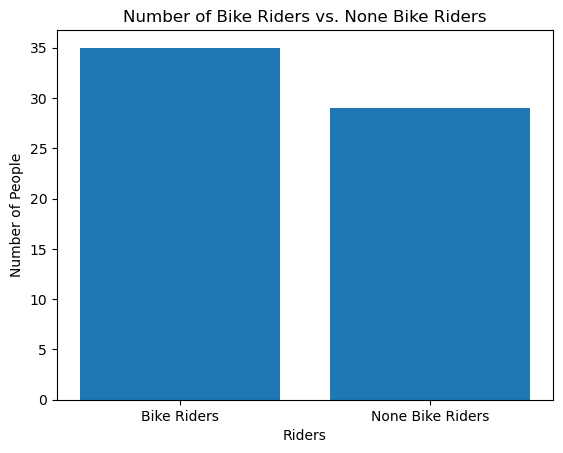

55% of the participants are bike riders
45% of the participants are NOT bike riders


In [13]:
# count number of bike rider and non-bike rider
bike_rider_count = quant_df['bike_rider'].value_counts()
bike_rider_yes = bike_rider_count[0] + bike_rider_count[2] + bike_rider_count[4]
bike_rider_no = bike_rider_count[1] + bike_rider_count[3]

# create bar plot
x = ['Bike Riders', 'None Bike Riders']
y = [bike_rider_yes, bike_rider_no]
plt.bar(x, y)

# add label to bar plot
plt.xlabel('Riders')
plt.ylabel('Number of People')
plt.title('Number of Bike Riders vs. None Bike Riders')

# display the plot
plt.show()

# show number of bike riders vs. none bike riders
bike_percent_yes = round(bike_rider_yes / (bike_rider_yes + bike_rider_no) * 100)
bike_percent_no = round(bike_rider_no / (bike_rider_no + bike_rider_yes) * 100)
print(f'{bike_percent_yes}% of the participants are bike riders')
print(f'{bike_percent_no}% of the participants are NOT bike riders')

#### Survey Question: What is your zip code? | Column: zipcode

In [14]:
# ENTER CODE HERE
...

#### Survey Question: Are you a ebike_rider? | Column: ebike_rider

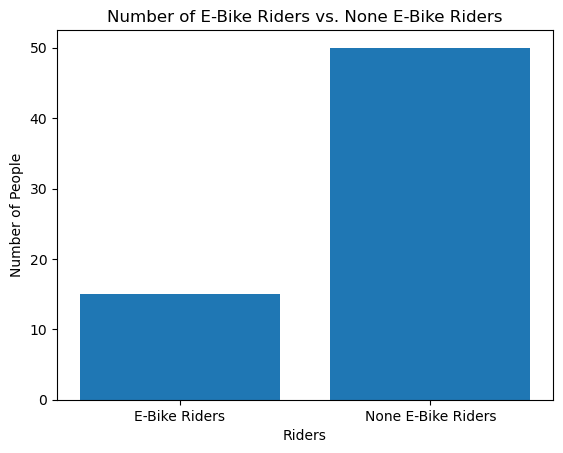

23% of the participants are e-bike riders
77% of the participants are NOT e-bike riders


In [15]:
# count number of ebike rider vs. non-ebike rider
ebike_rider_no = quant_df[quant_df['ebike_rider'] == 'no'].shape[0]
ebike_rider_yes = quant_df.shape[0] - ebike_rider_no

# create bar plot
x = ['E-Bike Riders', 'None E-Bike Riders']
y = [ebike_rider_yes, ebike_rider_no]
plt.bar(x, y)

# add label to bar plot
plt.xlabel('Riders')
plt.ylabel('Number of People')
plt.title('Number of E-Bike Riders vs. None E-Bike Riders')

# display the plot
plt.show()

# show number of bike riders vs. none bike riders
ebike_percent_yes = round(ebike_rider_yes / (ebike_rider_yes + ebike_rider_no) * 100)
ebike_percent_no = round(ebike_rider_no / (ebike_rider_no + ebike_rider_yes) * 100)
print(f'{ebike_percent_yes}% of the participants are e-bike riders')
print(f'{ebike_percent_no}% of the participants are NOT e-bike riders')

#### Survey Question: How do you commute - to work, school, or for other purposes? | Column: commute_purpose

In [16]:
quant_df['commute_purpose'].unique()

array(['i do not commute', 'car', 'public transportation', 'walking',
       'i dry to trolley station', 'bike', 'public transportation/uber',
       '1/week', 'electric car', 'car/walking', nan,
       'car to work & e bike', 'car & mts', 'car & walking',
       'walking(retired)', 'car &bike', 'bus', 'car - ev',
       'car and public transportation'], dtype=object)

#### Survey Question: How far (ROUND TRIP) do you commute for any purpose each day? | Column: miles

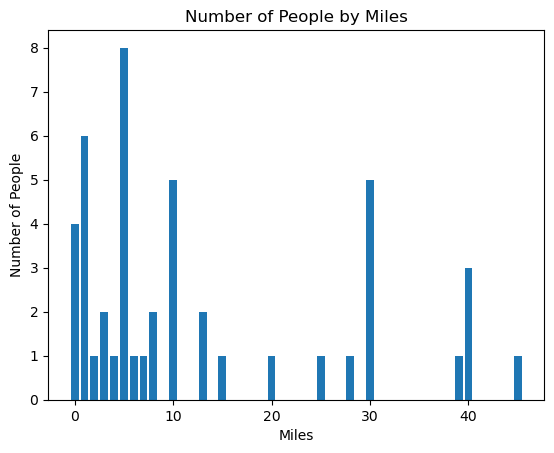

In [17]:
# count number of miles
miles_count = quant_df['miles'].value_counts()

# create bar plot
x = miles_count.index
y = miles_count.values
plt.bar(x, y)

# add label to bar plot
plt.xlabel('Miles')
plt.ylabel('Number of People')
plt.title('Number of People by Miles')

# display the plot
plt.show()

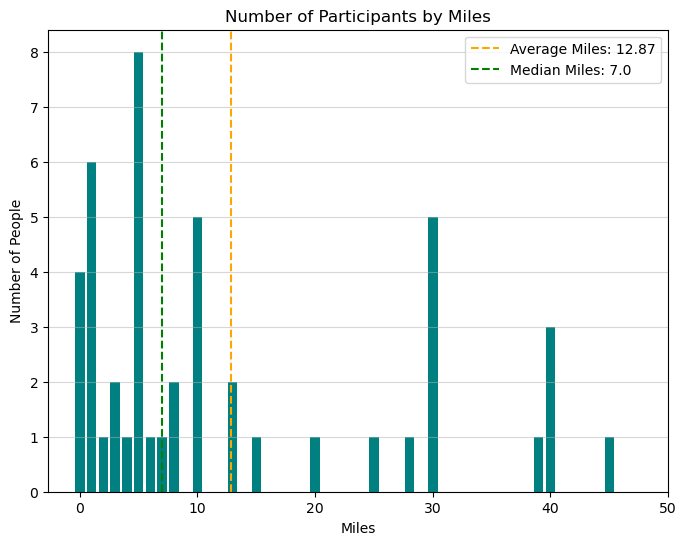

In [18]:
# count number of miles
mile_counts = quant_df['miles'].value_counts(sort = False)

# create bar plot
fig, ax = plt.subplots(figsize = (8, 6))
bars = ax.bar(mile_counts.index, mile_counts.values, color = 'teal')
ax.set_xlabel('Miles')
ax.set_ylabel('Number of People')
ax.set_title('Number of Participants by Miles')

# add a vertical line to show the average and median miles
ax.grid(axis = 'y', alpha = 0.5)
avg_miles = quant_df['miles'].mean()
med_miles = quant_df['miles'].median()
ax.axvline(x = avg_miles, color = 'orange', linestyle = '--', label = f'Average Miles: {avg_miles:.2f}')
ax.axvline(x = med_miles, color = 'green', linestyle = '--', label = f'Median Miles: {med_miles}')
ax.set_xticks(range(0, 51, 10))

# show the plot
ax.legend()
plt.show()

#### Survey Question: Would you commute by e-bike if given the opportunity? | Column: try_bike

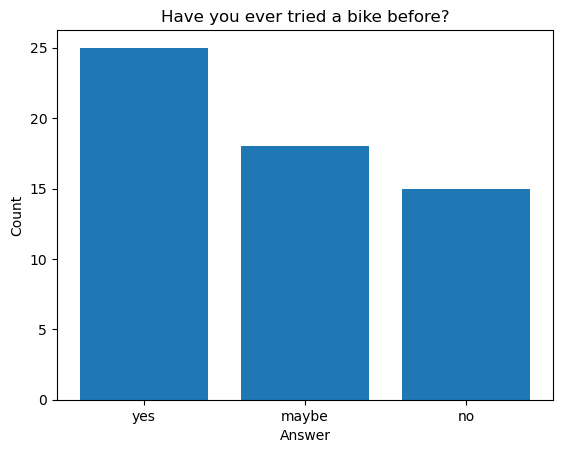

In [19]:
# Count the number of occurrences of each unique value in the try_bike column
try_bike_counts = quant_df['try_bike'].value_counts()

# Create a bar plot
plt.bar(try_bike_counts.index, try_bike_counts.values)

# Set the title and axis labels
plt.title('Have you ever tried a bike before?')
plt.xlabel('Answer')
plt.ylabel('Count')

# Show the plot
plt.show()

#### Survey Question: Do you know the differences between Class 1, Class 1, and Class 3 e-bikes? | Column: ebike_class

Text(0, 0.5, 'Count')

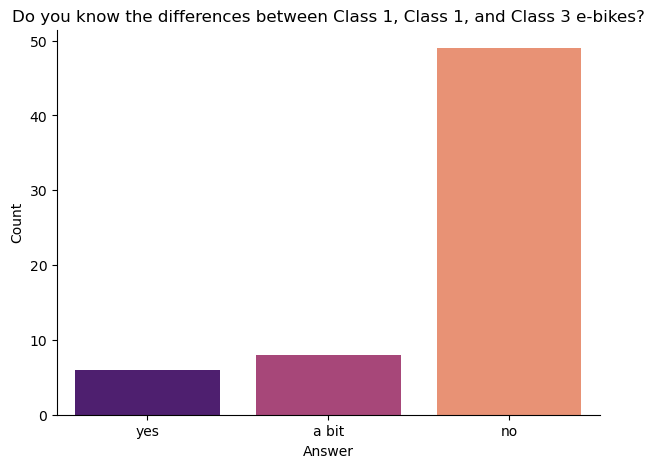

In [20]:
# Count the number of occurrences of each unique value in the ebike_class column
ebike_class_count = quant_df['ebike_class'].value_counts()

# Create a bar graph
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.barplot(x=ebike_class_count.index, y = ebike_class_count.values, palette='magma', order = ['yes', 'a bit', 'no'])

# Set title and labels to the graph
plt.title('Do you know the differences between Class 1, Class 1, and Class 3 e-bikes?')
plt.xlabel('Answer')
plt.ylabel('Count')


#### Survey Question: How comfortable would you be storing your bike in a private bike locker while you are commuting? | Column: private_locker

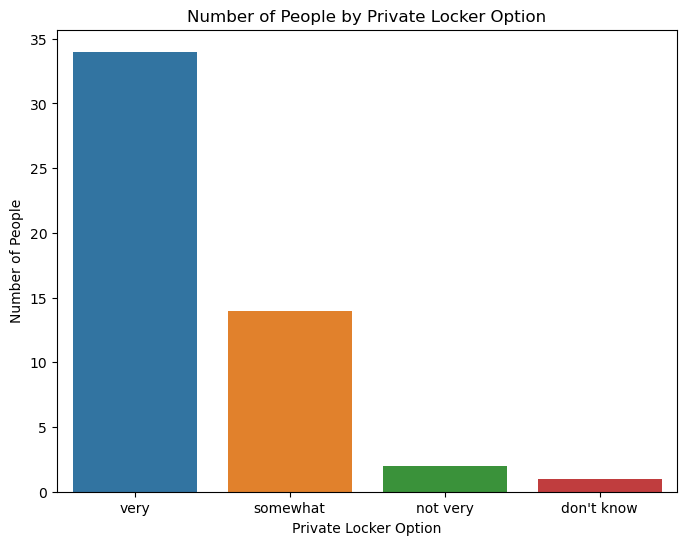

In [21]:
# Count the occurrences of each option in the 'private_locker' column
private_locker_counts = quant_df['private_locker'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(x=private_locker_counts.index, y=private_locker_counts.values)
plt.xlabel('Private Locker Option')
plt.ylabel('Number of People')
plt.title('Number of People by Private Locker Option')
plt.show()

#### Survey Question: How comfortable would you be storing your bike in a group bike locker while you are commuting? | Column: group_locker

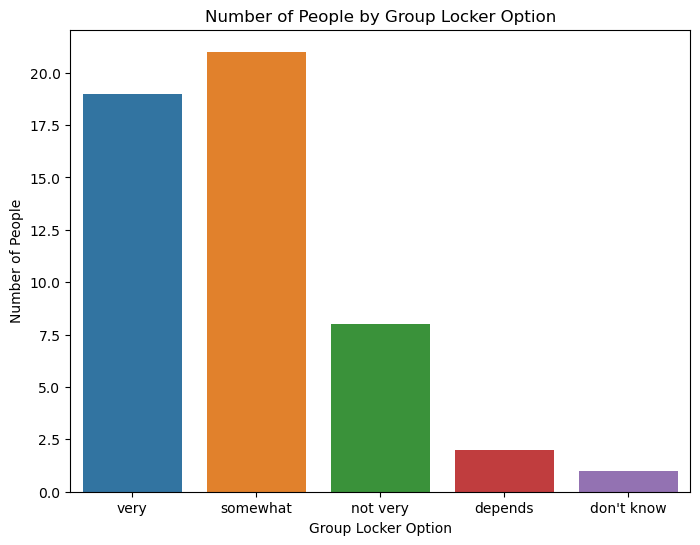

In [22]:
category_order = ['very', 'somewhat', 'not very', 'depends', "don't know"]
quant_df['group_locker'] = pd.Categorical(quant_df['group_locker'], categories=category_order, ordered=True)
group_locker_counts = quant_df['group_locker'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=group_locker_counts.index, y=group_locker_counts.values)
plt.xlabel('Group Locker Option')
plt.ylabel('Number of People')
plt.title('Number of People by Group Locker Option')
plt.show()

#### Survey Question: How familiar are you and those in your family with the rules of the road for e-bikes? | Column: ebike_rules

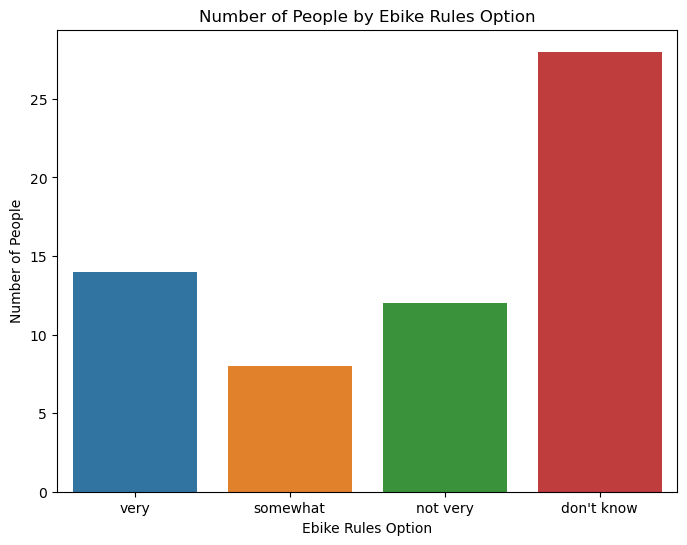

In [23]:
order = ['very', 'somewhat', 'not very', "don't know"]
ebike_rules_counts = quant_df['ebike_rules'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=ebike_rules_counts.index, y=ebike_rules_counts.values, order=order)
plt.xlabel('Ebike Rules Option')
plt.ylabel('Number of People')
plt.title('Number of People by Ebike Rules Option')
plt.show()

#### Survey Question: How concerned are you about e-bikes and e-bike safety in San Diego County? | Column: safty

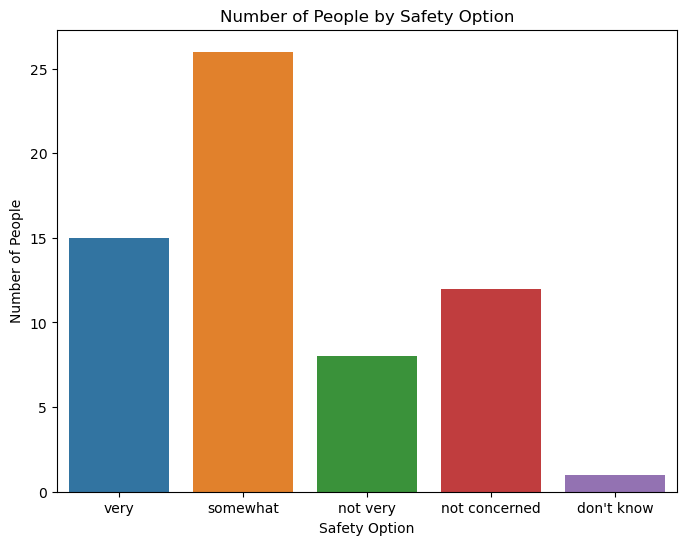

In [24]:
order = ['very', 'somewhat', 'not very', 'not concerned', "don't know"]
safety_counts = quant_df['safty'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=safety_counts.index, y=safety_counts.values, order=order)
plt.xlabel('Safety Option')
plt.ylabel('Number of People')
plt.title('Number of People by Safety Option')
plt.show()

#### Survey Question: Are you interested in learning more about e-bikes? | Column: interested

Text(0, 0.5, 'Count')

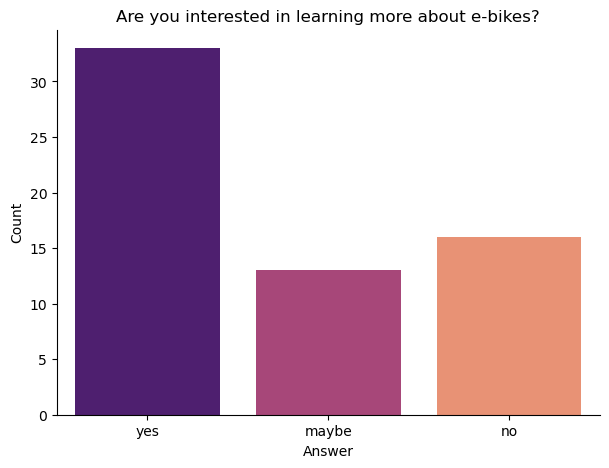

In [25]:
# Fix typo and category in answers
quant_df['interested'] = quant_df['interested'].str.strip()
quant_df['interested'] = quant_df['interested'].str.replace('may be', 'maybe')
quant_df['interested'] = quant_df['interested'].str.replace('already know', 'yes')
quant_df['interested'] = quant_df['interested'].str.replace('knows enough', 'yes')

# Count the number of occurrences of each unique value in the interested column
interested_count = quant_df['interested'].value_counts()

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.barplot(x=interested_count.index, y = interested_count.values, palette='magma', order = ['yes', 'maybe', 'no'])

# Set title and labels to the graph
plt.title('Are you interested in learning more about e-bikes?')
plt.xlabel('Answer')
plt.ylabel('Count')

## Part III: Correlation Analysis

### bike_rider vs. ibike_rider, persentage show by text

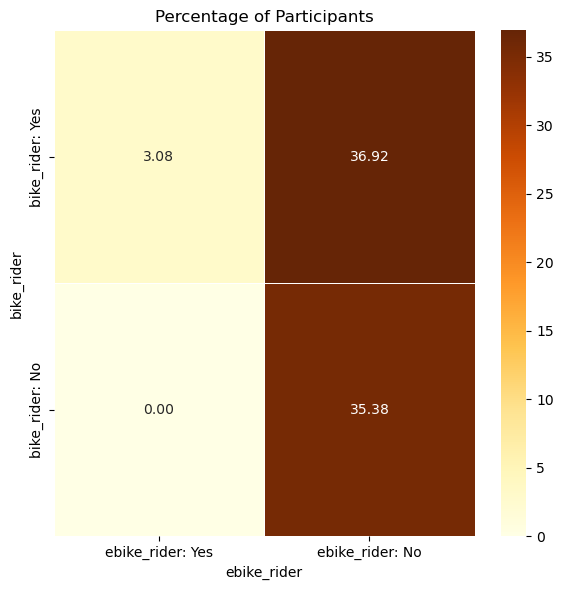

In [41]:
correlation = quant_df['bike_rider'].eq('yes').astype(int).corr(quant_df['ebike_rider'].eq('yes').astype(int))

yes_yes_count = quant_df[(quant_df['bike_rider'] == 'yes') & (quant_df['ebike_rider'] == 'yes')].shape[0]
yes_no_count = quant_df[(quant_df['bike_rider'] == 'yes') & (quant_df['ebike_rider'] == 'no')].shape[0]
no_yes_count = quant_df[(quant_df['bike_rider'] == 'no') & (quant_df['ebike_rider'] == 'yes')].shape[0]
no_no_count = quant_df[(quant_df['bike_rider'] == 'no') & (quant_df['ebike_rider'] == 'no')].shape[0]

total_count = len(quant_df)

yes_yes_percent = round((yes_yes_count / total_count) * 100, 2)
yes_no_percent = round((yes_no_count / total_count) * 100, 2)
no_yes_percent = round((no_yes_count / total_count) * 100, 2)
no_no_percent = round((no_no_count / total_count) * 100, 2)

data = [[yes_yes_percent, yes_no_percent], [no_yes_percent, no_no_percent]]

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(data, cmap='YlOrBr', annot=True, fmt=".2f", cbar=True, linewidths=0.5)

ax.set_xticklabels(['ebike_rider: Yes', 'ebike_rider: No'])
ax.set_yticklabels(['bike_rider: Yes', 'bike_rider: No'])

ax.set_xlabel('ebike_rider')
ax.set_ylabel('bike_rider')
ax.set_title('Percentage of Participants')

plt.tight_layout()
plt.show()

### bike rider vs. miles, bar graph

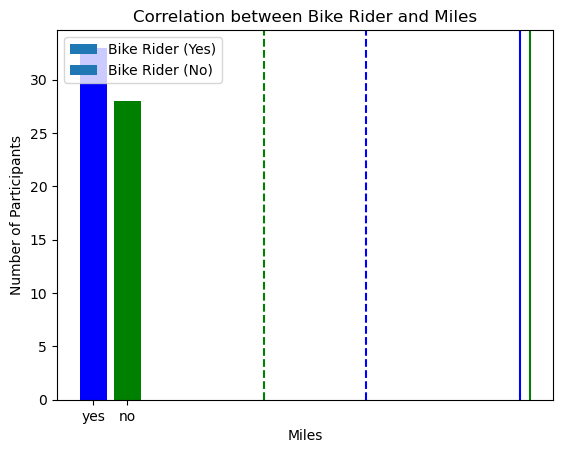

In [33]:
quant_df_cleaned = quant_df[(quant_df['bike_rider'] == 'yes') | (quant_df['bike_rider'] == 'no')]

mean_miles_yes = quant_df_cleaned[quant_df_cleaned['bike_rider'] == 'yes']['miles'].mean()
mean_miles_no = quant_df_cleaned[quant_df_cleaned['bike_rider'] == 'no']['miles'].mean()

dot_counts = quant_df_cleaned['bike_rider'].value_counts()

color_palette = ['blue', 'green']  # Add your desired colors here

bars = plt.bar(dot_counts.index, dot_counts.values, color=color_palette)

median_miles_yes = quant_df_cleaned[quant_df_cleaned['bike_rider'] == 'yes']['miles'].median()
median_miles_no = quant_df_cleaned[quant_df_cleaned['bike_rider'] == 'no']['miles'].median()

plt.axvline(median_miles_yes, color=color_palette[0], linestyle='--', label=f'Median Mile (Yes): {median_miles_yes:.2f}')
plt.axvline(median_miles_no, color=color_palette[1], linestyle='--', label=f'Median Mile (No): {median_miles_no:.2f}')

plt.axvline(mean_miles_yes, color=color_palette[0], linestyle='-', label=f'Mean Mile (Yes): {mean_miles_yes:.2f}')
plt.axvline(mean_miles_no, color=color_palette[1], linestyle='-', label=f'Mean Mile (No): {mean_miles_no:.2f}')

plt.xlabel('Miles')
plt.ylabel('Number of Participants')
plt.title('Correlation between Bike Rider and Miles')

legend_handles = [plt.bar([], [], color=color, label=f'Bike Rider ({response})')
                  for color, response in zip(color_palette, quant_df_cleaned['bike_rider'].unique())]

for handle, label in zip(legend_handles, ['Bike Rider (Yes)', 'Bike Rider (No)']):
    handle.set_label(label)

plt.legend(handles=legend_handles)
plt.show()

### ebike_rules vs. safety, persentage by text

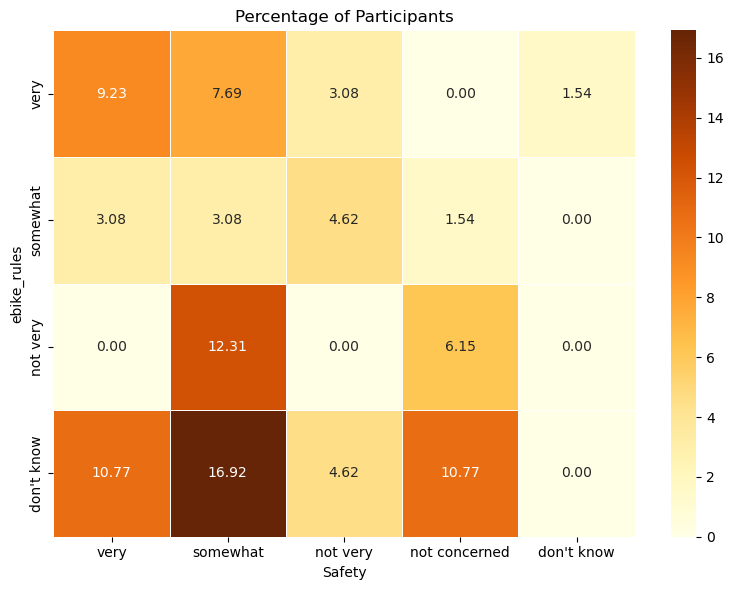

In [37]:
ebike_rules_categories = ['very', 'somewhat', 'not very', "don't know"]
safety_categories = ['very', 'somewhat', 'not very', 'not concerned', "don't know"]

percentages = []
for ebike_rule in ebike_rules_categories:
    row = []
    for safety in safety_categories:
        count = quant_df[(quant_df['ebike_rules'] == ebike_rule) & (quant_df['safty'] == safety)].shape[0]
        percent = round((count / total_count) * 100, 2)
        row.append(percent)
    percentages.append(row)

data = percentages

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data, cmap='YlOrBr', annot=True, fmt=".2f", cbar=True, linewidths=0.5)

ax.set_xticklabels(safety_categories)
ax.set_yticklabels(ebike_rules_categories)

ax.set_xlabel('Safety')
ax.set_ylabel('ebike_rules')
ax.set_title('Percentage of Participants')

plt.tight_layout()
plt.show()

### ebike_rules vs. safety, persentage by heatmap

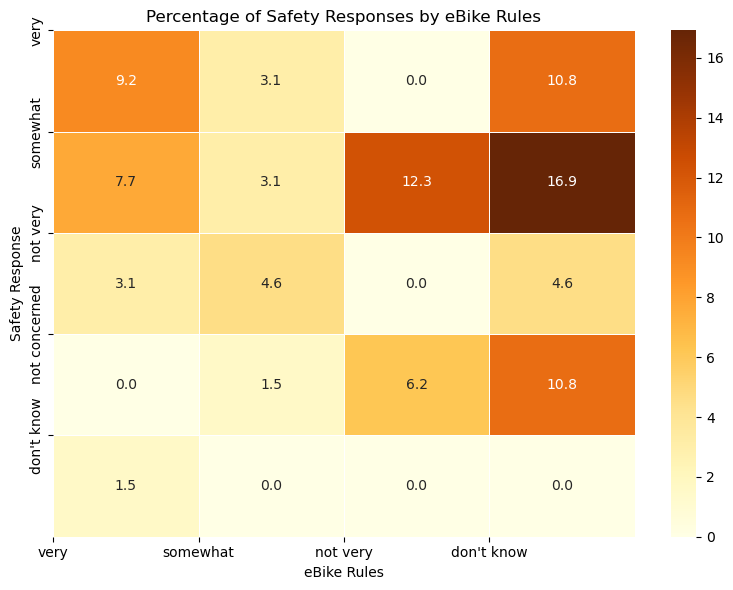

In [40]:
#heatmap
import matplotlib.patheffects as path_effects
safety_categories = ['very', 'somewhat', 'not very', 'not concerned', "don't know"]
ebike_rules_categories = ['very', 'somewhat', 'not very', "don't know"]

percentages = []
for safety in safety_categories:
    row = []
    for ebike_rule in ebike_rules_categories:
        count = quant_df[(quant_df['safty'] == safety) & (quant_df['ebike_rules'] == ebike_rule)].shape[0]
        percentage = (count / total_count) * 100
        row.append(percentage)
    percentages.append(row)

percentages = np.array(percentages)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(percentages, cmap='YlOrBr', annot=True, fmt=".1f", cbar=True, linewidths=0.5)

ax.set_xticks(np.arange(len(ebike_rules_categories)))
ax.set_yticks(np.arange(len(safety_categories)))
ax.set_xticklabels(ebike_rules_categories)
ax.set_yticklabels(safety_categories)

ax.set_xlabel('eBike Rules')
ax.set_ylabel('Safety Response')
ax.set_title('Percentage of Safety Responses by eBike Rules')

plt.tight_layout()
plt.show()

### private_locker vs. group_locker, persentage by heatmap

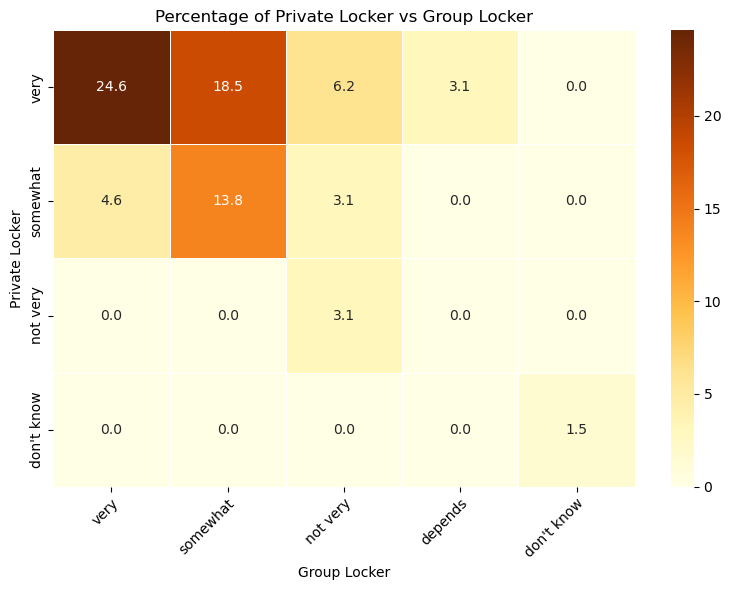

In [31]:
#heatmap
import seaborn as sns

private_locker_categories = ['very', 'somewhat', 'not very', "don't know"]
group_locker_categories = ['very', 'somewhat', 'not very', 'depends', "don't know"]

percentages = []
for private_locker in private_locker_categories:
    row = []
    for group_locker in group_locker_categories:
        count = quant_df[(quant_df['private_locker'] == private_locker) & (quant_df['group_locker'] == group_locker)].shape[0]
        percentage = (count / total_count) * 100
        row.append(percentage)
    percentages.append(row)

percentages = np.array(percentages)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(percentages, cmap='YlOrBr', annot=True, fmt=".1f", cbar=True, linewidths=0.5)

ax.set_xticks(np.arange(len(group_locker_categories)) + 0.5)
ax.set_yticks(np.arange(len(private_locker_categories)) + 0.5)
ax.set_xticklabels(group_locker_categories)
ax.set_yticklabels(private_locker_categories)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

ax.set_xlabel('Group Locker')
ax.set_ylabel('Private Locker')
ax.set_title('Percentage of Private Locker vs Group Locker')

plt.tight_layout()
plt.show()